Predict whether posts come from depression or suicide thread

Hannah Ho

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

import seaborn as sns #only responded to pip install (not pip3 install or conda install)
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import itertools

In [2]:
df_suicide = pd.read_csv('suicidewatch_posts.csv')
df_depression = pd.read_csv('depression_posts.csv')

In [3]:
# Create column 'Suicide', intialize with 1
df_suicide['Suicide'] = 1
df_depression['Depression'] = np.nan

print(len(df_suicide)) # Check
df_suicide.head(1) # Check

4447


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Suicide
0,New wiki on how to avoid accidentally encourag...,596,cz6nfd,SuicideWatch,https://www.reddit.com/r/SuicideWatch/comments...,157,We've been seeing a worrying increase in pro-s...,2019-09-03 18:49:51,eyx1qcc,I'm sorry did you say suicide fetishists? As i...,2019-09-03 23:34:05,Y,0 days 04:44:14.000000000,1


In [4]:
# Create column 'Depression', intialize with 0
df_depression['Suicide'] = np.nan
df_depression['Depression'] = 0

print(len(df_depression)) # Check
df_depression.head(1) # Check

4035


,title,score,p_id,subreddit,url,num_comments,body,p_timestamp,c_id,comment,c_timestamp,Post_Reply,Time_to_Comment,Depression,Suicide
0,Regular Check-In Post,970,cml6ni,depression,https://www.reddit.com/r/depression/comments/c...,5523,Welcome to /r/depression's check-in post - a p...,2019-08-06 06:12:33,ew4joli,I gave in to my depression and stayed home ins...,2019-08-06 20:21:04,Y,0 days 14:08:31.000000000,0,NaN


In [5]:
# Merge the two datasets
frames = [df_depression, df_suicide]
df_merged = pd.concat(frames)

print('df_merged length:', len(df_merged)) # Check
df_merged.head(1) # Check

print('Bayesian accuracy')
print(4447/8482)
print(1-4447/8482)

df_merged length: 8482
Bayesian accuracy
0.5242867248290497
0.4757132751709503


C:\Users\Hannah\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Split into train and test set
df_merged['Target'] = df_merged['Suicide'].combine_first(df_merged['Depression'])

df_merged['Target'].value_counts() # Check
df_merged.head(3)

,Depression,Post_Reply,Suicide,Time_to_Comment,body,c_id,c_timestamp,comment,num_comments,p_id,p_timestamp,score,subreddit,title,url,Target
0,0.0,Y,NaN,0 days 14:08:31.000000000,Welcome to /r/depression's check-in post - a p...,ew4joli,2019-08-06 20:21:04,I gave in to my depression and stayed home ins...,5523,cml6ni,2019-08-06 06:12:33,970,depression,Regular Check-In Post,https://www.reddit.com/r/depression/comments/c...,0.0
1,0.0,Y,NaN,3 days 01:36:58.000000000,Welcome to /r/depression's check-in post - a p...,ewejn04,2019-08-09 07:49:31,Currently experiencing: Extreme sadness (but c...,5523,cml6ni,2019-08-06 06:12:33,970,depression,Regular Check-In Post,https://www.reddit.com/r/depression/comments/c...,0.0
2,0.0,Y,NaN,1 days 08:22:00.000000000,Welcome to /r/depression's check-in post - a p...,ew6orjt,2019-08-07 14:34:33,i’m just too scared to kill myself. i wish i c...,5523,cml6ni,2019-08-06 06:12:33,970,depression,Regular Check-In Post,https://www.reddit.com/r/depression/comments/c...,0.0


In [7]:
# Clean comments

sw = stopwords.words('english')

# Replace '\n' and '\\' with ''
df_merged['comment'] = df_merged['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove stopwords
# df_merged['comment_sw'] = df_merged['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)])).astype(str)

# Remove special characters; make all characters lowercase
df_merged['comment_sw_p'] = df_merged['comment'].str.replace('[^\w\s]', '').str.lower()

# Create boolean for deleted comments
df_merged['deleted'] = np.where(df_merged['comment']=='[deleted]', 'Y', 'N')

# Create column with comment length
df_merged['comment_length'] = 0

for i in range(len(df_merged)):
    df_merged['comment_length'].iloc[i] = len(df_merged['comment'].iloc[i].split(' '))
    
df_merged['comment_length'] = np.where(df_merged['deleted']=='Y', np.NaN, df_merged['comment_length'])
df_merged.head(1)

C:\Users\Hannah\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Depression,Post_Reply,Suicide,Time_to_Comment,body,c_id,c_timestamp,comment,num_comments,p_id,p_timestamp,score,subreddit,title,url,Target,comment_sw_p,deleted,comment_length
0,0.0,Y,NaN,0 days 14:08:31.000000000,Welcome to /r/depression's check-in post - a p...,ew4joli,2019-08-06 20:21:04,I gave in to my depression and stayed home ins...,5523,cml6ni,2019-08-06 06:12:33,970,depression,Regular Check-In Post,https://www.reddit.com/r/depression/comments/c...,0.0,i gave in to my depression and stayed home ins...,N,92.0


Train and run Logistic Regression model using unigrams and bigrams

In [9]:
# Sublinear tf scaling: https://nlp.stanford.edu/IR-book/html/htmledition/sublinear-tf-scaling-1.html
# min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. 
# norm: cosine similarity between two vectors is their dot product when l2 norm has been applied
# ngram_range: an ngram_range of (1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
tfidf1 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,1))
tfidf12 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,2))
tfidf123 = TfidfVectorizer(sublinear_tf = True, min_df = 3, norm = 'l2', ngram_range = (1,3))
# tfidf12 = TfidfVectorizer(sublinear_tf = True, min_df = 5, norm = 'l2', ngram_range = (1,2))

features1 = tfidf1.fit_transform(df_merged.comment_sw_p).toarray()
features12 = tfidf12.fit_transform(df_merged.comment_sw_p).toarray()
features123 = tfidf123.fit_transform(df_merged.comment_sw_p).toarray()

print(features1.shape)
print(features12.shape)
print(features123.shape)# Each comment is represented by 6948 features, which are tf-idf scores for various unigrams and bigrams

(8482, 4803)
(8482, 23876)
(8482, 35062)


In [10]:
def train_test_split_predict_verify(features, targets, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state = random_state)
    
    # Predict subreddit class based on tf-idf scores using Logistic Regression model
    models = [LogisticRegression(penalty = 'l2', random_state = random_state, solver = 'liblinear')]
    CV = 5
    entries = []
    class_names = ['Depression', 'Suicide']

    for model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        conf_matrix = confusion_matrix(y_test, y_pred)
        print (conf_matrix)

        np.set_printoptions(precision = 2)

        # Plot non-normalized and normalized confusion matrix
        titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
        for title, normalize in titles_options:
            disp = plot_confusion_matrix(model, X_test, y_test, display_labels = class_names, cmap = plt.cm.Blues, normalize = normalize)
            disp.ax_.set_title(title)
            print(title)
            print(disp.confusion_matrix)
        plt.show()

        model_name = model.__class__.__name__
        print (model_name)

        accuracies = cross_val_score(model, features, df_merged.Target, scoring = 'accuracy', cv = CV) # cross_val_score(estimator, X, y)
        for fold_index, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_index, accuracy))

    cv_df = pd.DataFrame(entries, columns = ['model_name', 'fold_index','accuracy'])
    cv_df

[[609 404]
 [349 759]]
Confusion matrix, without normalization
[[609 404]
 [349 759]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.31 0.69]]


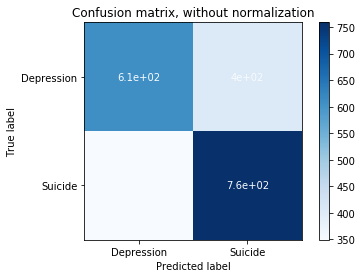

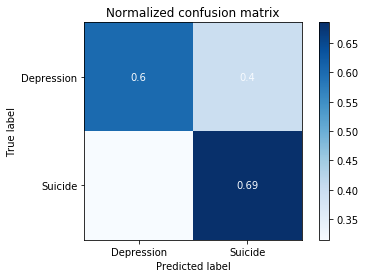

LogisticRegression


In [11]:
# Prediction using unigrams performed about as well as n-grams > 1.
# This implies tf-idf scores of single words can reasonably predict whether a comment was posted in the suicide or depression thread.
train_test_split_predict_verify(features1, df_merged['Target'])

[[612 401]
 [324 784]]
Confusion matrix, without normalization
[[612 401]
 [324 784]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.29 0.71]]


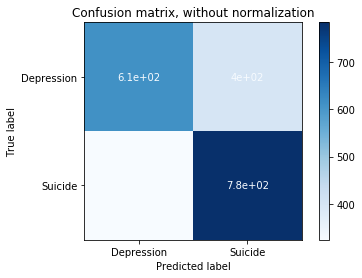

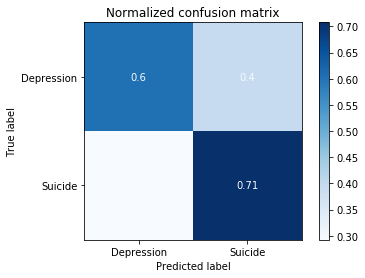

LogisticRegression


In [12]:
train_test_split_predict_verify(features12, df_merged['Target'])

[[610 403]
 [324 784]]
Confusion matrix, without normalization
[[610 403]
 [324 784]]
Normalized confusion matrix
[[0.6  0.4 ]
 [0.29 0.71]]


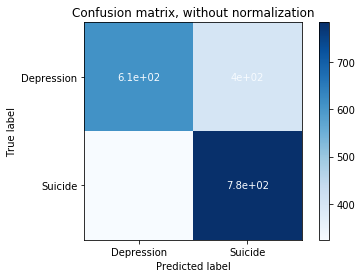

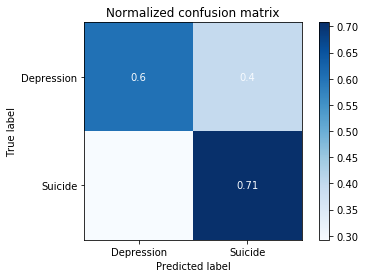

LogisticRegression


In [13]:
train_test_split_predict_verify(features123, df_merged['Target'])

In [14]:
#Depression
d = list(itertools.chain(*[comment.split() for comment, tgt in zip(df_merged['comment_sw_p'], df_merged['Target']) if tgt == 0]))
print("Depression most common words: ")
depression_most_common = Counter(d)

# Normalize term frequencies
number_tokens = sum(depression_most_common.values())

for word, frequency in depression_most_common.most_common(20):
    word_norm = frequency/number_tokens

Depression most common words: 


In [15]:
# Top 5 words in merged dataset by tf-idf score

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_merged.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print('Top 5 words in merged dataset by tf-idf score')
top_n

Top 5 words in merged dataset by tf-idf score


array(['activities', 'complicated', 'unfair', 'sooner', 'stranger'],
      dtype='<U16')

In [16]:
# Top 5 words in depression dataset by tf-idf score

# Replace '\n' and '\\' with ''
df_depression['comment'] = df_depression['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove special characters; make all characters lowercase
df_depression['comment_sw_p'] = df_depression['comment'].str.replace('[^\w\s]', '').str.lower()

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_depression.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print('Top 5 words in depression dataset by tf-idf score ')
top_n

Top 5 words in depression dataset by tf-idf score 


array(['escape', 'whatever', 'binge', 'helps', 'reminding'], dtype='<U16')

In [17]:
# Top 5 words in suicide dataset by tf-idf score

# Replace '\n' and '\\' with ''
df_suicide['comment'] = df_suicide['comment'].astype(str).str.replace('\n', '').str.replace('\\', '')

# Remove special characters; make all characters lowercase
df_suicide['comment_sw_p'] = df_suicide['comment'].str.replace('[^\w\s]', '').str.lower()

feature_array = np.array(tfidf1.get_feature_names())
response = tfidf1.transform(df_suicide.comment_sw_p)
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 5
top_n = feature_array[tfidf_sorting][:n]
# len(feature_array)
# response
print ('Top 5 words in suicide dataset by tf-idf score')
top_n

Top 5 words in suicide dataset by tf-idf score


array(['activities', 'complicated', 'unfair', 'sooner', 'stranger'],
      dtype='<U16')

In [18]:
#Suicide
s = list(itertools.chain(*[comment.split() for comment, tgt in zip(df_merged['comment_sw_p'], df_merged['Target']) if tgt == 1])) 
print("Suicide most common words: ")
suicide_most_common = Counter(s)
suicide_most_common.most_common(20)

Suicide most common words: 


[('i', 6392),
 ('to', 6133),
 ('you', 6078),
 ('and', 4469),
 ('the', 3943),
 ('a', 3582),
 ('it', 2898),
 ('that', 2702),
 ('of', 2412),
 ('is', 2004),
 ('in', 1859),
 ('for', 1810),
 ('but', 1708),
 ('my', 1592),
 ('your', 1582),
 ('have', 1509),
 ('be', 1442),
 ('im', 1427),
 ('just', 1378),
 ('me', 1308)]

Word Embeddings